In [74]:
import numpy as np
import climlab # package used for calculating orbital parameters overtime
from climlab.solar.orbital import OrbitalTable
from climlab.solar.insolation import daily_insolation
import matplotlib.pyplot as plt
from scipy.sparse import diags



#timesteping for calculations
t_i = 0
t_f = -50000 #run model for the past 50,000 years
d_t = 0.1  #use time step of about 36 days, needed for stability
t = np.arange(t_f, t_i+1, d_t)

#timesteping for orbital parameters
d_t_orb = 100 #use time step of 100 years
t_orb = np.arange(t_f, t_i+1, d_t_orb)
t_kyr = (t_orb/(1000)) # years in kyr, needed to calculate orbital parameters


#grid spacing for calculations
x_i = 0 # meters,  corresponds to 74 degrees N latitute (northern boundary) 
x_f = 1000000 # meters,  corresponds to 60 degrees N latitude (southern boundary)
x = np.linspace(x_i, x_f, 38)
d_x = x_f/len(x)

#grid spacing for orbital parameters
x_i_orb = 65 # degrees North latitude (southern boundary)
x_f_orb = 74 # degrees North latitude (northern boundary)
d_x_orb= 0.25 #0.5 degrees as spacial step equivalent to 55km
x_orb = np.arange(x_i_orb, x_f_orb+0.25, d_x_orb)

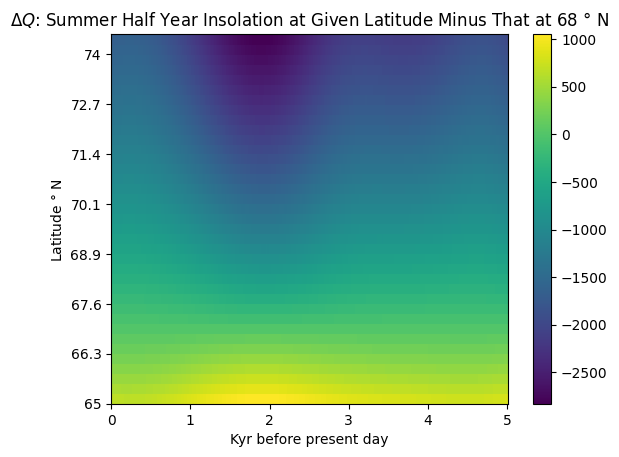

In [75]:
#Calculating Orbital Parameters
days = np.linspace(1,365.24, 365)/365 * 365.24
orb = OrbitalTable.interp(kyear=t_kyr ) #calculate orbital parameters for past 700,000 years, every 100 years

Q = daily_insolation(x_orb, days, orb) #calculate daily insolation per every 500 years based on orbit parameters


#Calculating Summer Half-Year Insolation
delta_Q = np.zeros((len(x_orb), len(t_kyr)))

for i in range(len(t_kyr)):
    daily_68 = Q[7, :, i]
    median_insolation_68 = np.median(daily_68)
    summer_total_68 = sum(daily_68[daily_68>median_insolation_68])
    for j in range(len(x_orb)):
        daily = Q[j,:, i]
        median_insolation = np.median(daily)
        summer_total = sum(daily[daily> median_insolation])
        #now need to subtract the 63 degree N summer half year from each latitute to find delta Q
        delta_Q[j, i] = summer_total - summer_total_68

# Plotting Delta Q
plt.figure()
ax = plt.axes()
plt.pcolor(delta_Q)
plt.colorbar()
ax.set_xticks([0, 100, 200, 300, 400, 500], ["0", "1", "2", "3", "4", "5"])
ax.set_yticks([0, 5, 10, 15, 20, 25, 30, 35],[ "65", "66.3", "67.6",  "68.9", "70.1", "71.4", "72.7", "74" ])
plt.xlabel("Kyr before present day")
plt.ylabel("Latitude $\degree $ N ")
plt.title("$\Delta Q$: Summer Half Year Insolation at Given Latitude Minus That at 68 $\degree$ N" )
plt.show()

In [76]:
# Calculating Accumulation Based On Orbital Parameters

k = 25 #meters light-years^-1 day, insolation sensitivity
a = 0.81e-3 #years^-1
b = 0.3e-6 #meters^-3 years^-1

x_dis_south_km = np.array([0,28, 56, 83, 111, 139,  167, 194, 222, 250, 278, 306, 333, 361, 389, 
                           417, 444, 472, 500, 528, 556, 583, 611, 639, 667, 694, 722, 750, 778, 
                           806, 833, 861, 889, 917, 945, 972, 1000 ]) # Distance from 74 N to the other spacial points in km

x_dis_south = x_dis_south_km * 1000

E0 = (x_dis_south * 9e-4) - 6.57e-2 # Equlibrium Line


def E(t):
    return E0 + k * delta_Q[:,t] 

# Calculates Ice Accumulation Based on Year
def G(t, h):
    G_vec = np.zeros(len(h))
    E_vals = E(t)
    for i in range(len(h)-1):
        if (h[i] - E_vals[i] >= 1500):
            G_vec[i] = a*(h[i]-E_vals[i]) - b*(h[i]-E_vals[i])**2
        else:
            G_vec[i] = 0.56
    return G_vec

In [82]:
#Solve Non Linear Diffusion
A = 5.77e-4 #meters^-3 years^-1
alpha = 5
beta = 2

# Initialize glacier 
# want the northern part of glacier to be 10 m and decrease moving south so the southern border is 0 m
h_ini = np.linspace(920, 0, len(x)) 


# calculate diffusivity based on time step
def D(H_vec):
    Diff = np.zeros(len(H_vec))
    Diff = ((abs(np.gradient(H_vec, d_x))**beta * H_vec**alpha)  / (2*d_x)**beta ) * A * 0.7**(beta+1)
    return Diff

## Functions to calculate coefficients ##
def Alpha(D_vec):
    Alpha_diag = np.zeros((len(D_vec))-1)
    for i in range(1, len(D_vec)-1):
        Alpha_diag[i-1] = d_t/(4*d_x**2) * ( -D_vec[i+1] + D_vec[i-1] + 4 * D_vec[i])
    Alpha_diag[-1] = 0
    return Alpha_diag

def Beta(D_vec):
    Beta_diag = np.zeros(len(D_vec))
    for i in range(1, len(D_vec)-1):
        Beta_diag[i] = d_t * ( (-2 * D_vec[i]) / (d_x**2) + (1/d_t))    
    Beta_diag[0] = 1
    Beta_diag[-1] = 1
    return Beta_diag

def Gamma(D_vec):
    Gamma_diag = np.zeros(len(D_vec)-1)
    for i in range(1, len(D_vec)-1):
        Gamma_diag[i] = (d_t)/(4*d_x**2) * ( D_vec[i+1] - D_vec[i-1] + 4 * D_vec[i])
        
    Gamma_diag[0] = -1
    return Gamma_diag


# Solving equation in loop

def SolvePDE(use_orbital_params):
    # Initializing
    if (use_orbital_params == False):
        h_ini = np.linspace(10, 0, len(x)) 
    else:
        h_ini = np.linspace(920, 0, len(x)) 
    
    sols = np.zeros((len(x), len(t)))
    D_ini = D(h_ini)

    diffs = np.zeros((len(D_ini), len(t)))
    sols[:, 0] = h_ini
    diffs[:, 0] = D_ini
    h = h_ini
    for i in range(len(t)-2):
        if (i % 50000 == 0):
            percent = int((i / 500000)*100)
            print(f"{percent} % Completed")

        #Solve for diffusivity value at each grid point
        Diffusivity = D(h)
        diffs[:, i] = Diffusivity
        Cd = Diffusivity*d_t / d_x**2
        
        #calculate entries in P matrix
        lower_diag = Alpha(Diffusivity)
        center_diag = Beta(Diffusivity)
        upper_diag = Gamma(Diffusivity)

        #Build M matrix to solve
        diagonals = [lower_diag, center_diag, upper_diag]
        M = diags(diagonals, [-1, 0, 1]).toarray()

        #Add yearly accumulation 
        if (use_orbital_params == True):
            if (i % 100 == 0): # Recalculate accumulation rates every 100 years 
                G_vals = G(int(i/1000), h)/1000
                h = h + (d_t * G_vals)
            else:
                h = h + (d_t * G_vals)
        else:
            h = h + (d_t * 1) # uniform accumulation of 1 meter per year


        h[-1] = 0

        h_new = np.matmul(M, h)
        h_new    = np.maximum(h_new,0)
        h_new[0] = h[0]
        h = h_new

        #update solutions
        sols[:, i+1] = h
    return diffs, sols

diffs_unif_acc, sols_unif_acc = SolvePDE(False)
    

0 % Completed
10 % Completed
20 % Completed
30 % Completed
40 % Completed
50 % Completed
60 % Completed
70 % Completed
80 % Completed
90 % Completed
100 % Completed


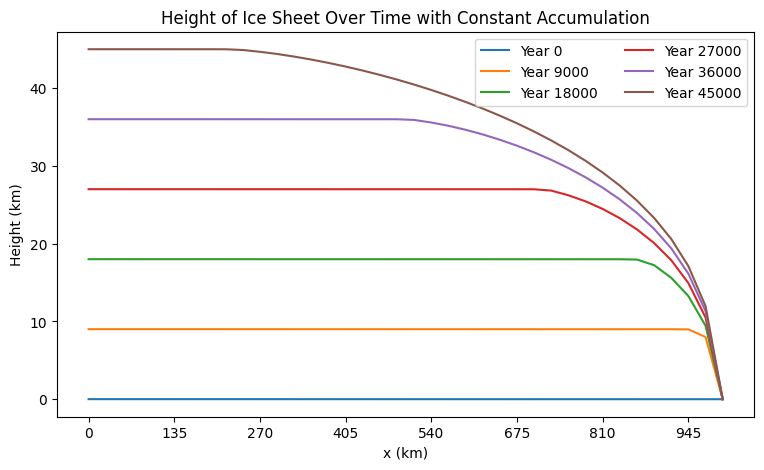

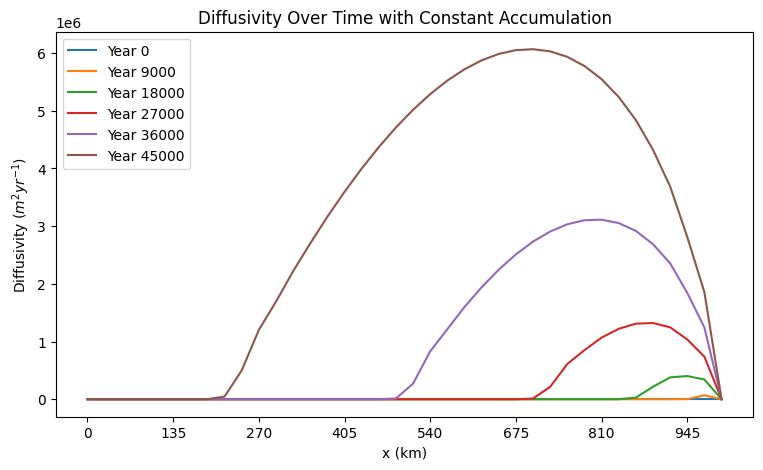

In [87]:
plt.figure(figsize=(9, 5))
ax = plt.axes()
for i in range(len(t)-1):
    if (i % 90000 == 0):
        year = int(i*d_t)
        plt.plot(sols_unif_acc[:, i], label=f"Year {year}")

ax.set_yticks([0, 10000, 20000, 30000, 40000], ["0", "10", "20", "30", "40"])
ax.set_xticks([0, 5, 10, 15, 20, 25, 30, 35],[ "0", "135", "270",  "405", "540", "675", "810", "945" ])
plt.legend(ncol = 2)
plt.xlabel("x (km)")
plt.ylabel("Height (km)")
plt.title("Height of Ice Sheet Over Time with Constant Accumulation")
plt.show()

plt.figure(figsize=(9, 5))
ax = plt.axes()
for i in range(len(t)-1):
    if (i % 90000 == 0):
        year = int(i*d_t)
        plt.plot(diffs_unif_acc[:, i], label=f"Year {year}")
plt.legend()
ax.set_xticks([0, 5, 10, 15, 20, 25, 30, 35],[ "0", "135", "270",  "405", "540", "675", "810", "945" ])
plt.xlabel("x (km)")
plt.ylabel("Diffusivity ($m^2 yr^{-1}$)")
plt.title("Diffusivity Over Time with Constant Accumulation")
plt.show()


In [86]:
diffs, sols = SolvePDE(True)


0 % Completed
10 % Completed
20 % Completed
30 % Completed
40 % Completed
50 % Completed
60 % Completed
70 % Completed
80 % Completed
90 % Completed
100 % Completed


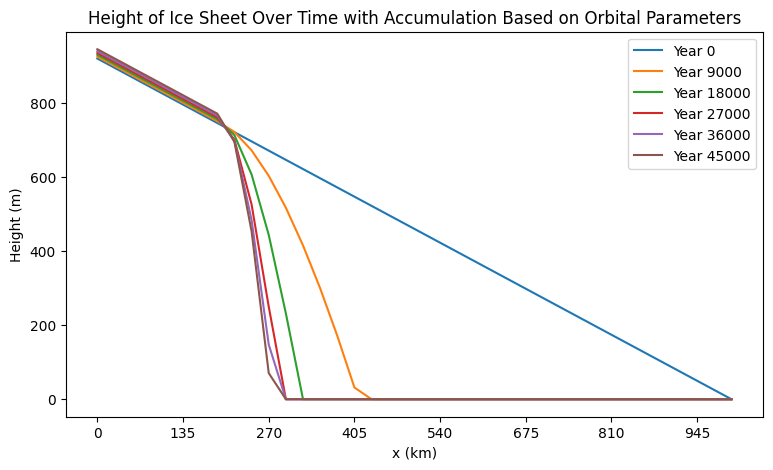

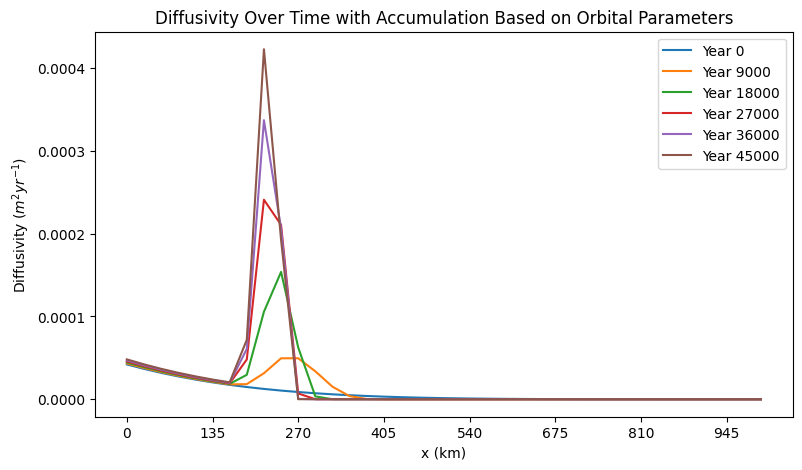

In [67]:
plt.figure(figsize=(9, 5))
ax = plt.axes()
for i in range(len(t)-1):
    if (i % 90000 == 0):
        year = int(i*d_t)
        plt.plot(sols[:, i], label=f"Year {year}")

plt.legend()
ax.set_xticks([0, 5, 10, 15, 20, 25, 30, 35],[ "0", "135", "270",  "405", "540", "675", "810", "945" ])
plt.xlabel("x (km)")
plt.ylabel("Height (m)")
plt.title("Height of Ice Sheet Over Time with Accumulation Based on Orbital Parameters")
plt.show()


plt.figure(figsize=(9, 5))
ax = plt.axes()
for i in range(len(t)-1):
    if (i % 90000 == 0):
        year = int(i*d_t)
        plt.plot(diffs[:, i], label=f"Year {year}")

plt.legend()
ax.set_xticks([0, 5, 10, 15, 20, 25, 30, 35],[ "0", "135", "270",  "405", "540", "675", "810", "945" ])
plt.xlabel("x (km)")
plt.ylabel("Diffusivity ($m^2 yr^{-1}$)")
plt.title("Diffusivity Over Time with Accumulation Based on Orbital Parameters")
plt.show()
